In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import numpy as np
import cv2
from scipy.interpolate import Rbf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.ndimage import convolve
from matplotlib import colors
from scipy import interpolate
from scipy.interpolate import BSpline
from scipy.interpolate import make_interp_spline
from scipy.interpolate import make_lsq_spline
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import IMPERIAL_LENGTH
from matplotlib_scalebar.scalebar import ScaleBar

In [13]:
# ------------Keep it------------------------------#
error=0.0008
lower=485
upper=1200
# ------------Keep it------------------------------#

# Num correspond to the horizontal interpolation number: E.G. 14 means the interpolation map have 14 pixels in horizontal direction
Num=14

#num correspond to the vertical interpolation number: E.G. 32 means the interpolation map have 32 pixels in vertical direction
num=32

#Check the comment in raw data clean
albnum=[0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3050,3100]
alanum=[0,100,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3100]
sionum=[0,100,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3100]
sianum=[0,100,250,500,750,1250,1500,1750,2000,2250,2500,2750,3000,3100]
sibnum=[0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3050,3100]
numbers=[0,100,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3050,3100]
number=['0000','0100','0250','0500','0750']
label=['A','B','C']
total=[albnum,alanum,sionum,sionum,sionum,sianum,sibnum]
for i in range(1000,3001,250):
    number.append(str(i))
number.append('3050')
number.append('3100')
fnumber=[]
for iii in number:
    fnumber.append(int(iii))
dfys={}
dfxs={}
dfnan={}
RR=0

#put the energy level in the xzs 
xzs=[0.154]
for x in xzs:
    yt=[]
    ytn=[]
    for k in ['AL-B','AL-A','SiO2-A','SiO2-B','SiO2-C','SiC-A','SiC-B']:
            ys=[]
            yns=[]
            xs=[]
            for j in number:
                try:
                    df=pd.read_table('3p1um-{}-10-1s-{}nm-Subtracted-NElectrons-SM.dat'.format(k,j))
                    df.columns=['energyloss','intensity']
                    E=df['energyloss'][lower:upper]
                    I=df['intensity'][lower:upper]
                    df.set_index('energyloss',inplace=True)
                    Tcx=[]
                    Tcy=[]
                    for column in df.index:
                        if column>(-error+x) and column<(x+error):
                            y=df.loc[column].values[0]
                            if k=='SiO2-A' or k=='SiO2-C':
                                y=y-0.009
                            elif k=='SiO2-B':
                                y=y-0.0115
                            elif k=='SiC-A' or k=='SiC-B':
                                y=y-0.00
                            else:
                                y=y-0
                            RR+=1
                            Tcx.append(column)
                            Tcy.append(y)
                            if RR==2:
                                RR=0
                                break
                    Newy=((Tcy[1]-Tcy[0])/(Tcx[1]-Tcx[0])*x+(Tcy[1]-((Tcy[1]-Tcy[0])*Tcx[1])/(Tcx[1]-Tcx[0])))
                    ys.append(Newy)
                except Exception as e:
                    pass
            ytn.append(ys)
            yt.append(ys)
    dfys['EEL_Compoent_{}_Line_{}'.format(x,i)]=yt
    dfnan['EEL_Compoent_{}_Line_{}'.format(x,i)]=ytn
df3 = pd.DataFrame.from_dict(dfys, orient='index')
df2 = pd.DataFrame.from_dict(dfnan, orient='index')
stelement=['AlB','AlA','SiO2A','SiO2B','SiO2C','SiCA','SiCB']
whole={}
whole1={}
whole2={}

# Vertical Interpolation # 
## B-spline K=5##
#### Method: scipy. make_lsq_spline ####

In [14]:
a,b=df2.shape
z=0
for row in range(0,a):
    co=0
    y=df2.iloc[row].values
    y1=df3.iloc[row].values
    for value,V in zip(y,y1):
        pos=np.array(total[co])-1550
        pos1=np.array(total[co])
        c=['c-']
        #Change the K value here: work in maximum 8? depend on the number of raw data
        k=5
        X = pos
        t = [-1, 0,1]
        t = np.r_[(X[0],)*(k+1),t,(X[-1],)*(k+1)]
        spl = make_lsq_spline(X, value, t, k)
        spl1 = make_lsq_spline(X, V, t, k)
        xnew=np.linspace(-1550,1550,num)
        co=co+1
        xp = np.linspace(0,3100,32)
        whole['EEL={}_line_{}'.format(xzs[row],stelement[z])]=spl1(xnew)
        whole1['EEL={}_line_{}'.format(xzs[row],stelement[z])]=spl(xnew)
        z+=1
        if z==len(stelement):
            z=0
finaldf1 =pd.DataFrame.from_dict(whole1, orient='index')
finaldf =pd.DataFrame.from_dict(whole, orient='index')

# Horizontal Interpolation #
# RBF: Cubic #
#### Method scipy.Rbf ####

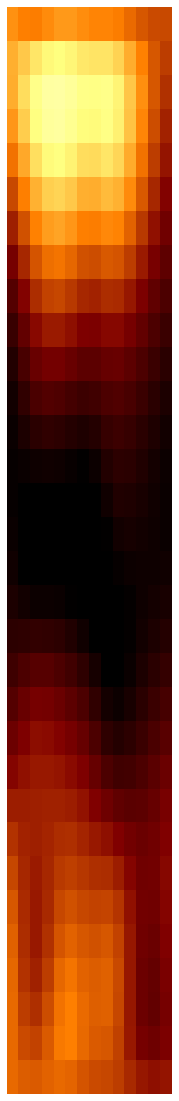

In [15]:
pos=np.array([0,10,30,40,50,70,80])
R,C=finaldf1.shape
for j in range(1,round(R/7)+1):
    subnew1={}
    subnew2={}
    for i in range(1,C+1):
        qq=finaldf1.iloc[(j-1)*7:j*7,i-1:i].values.flatten()
        qq1=finaldf.iloc[(j-1)*7:j*7,i-1:i].values.flatten()
        X = pos-40
        xnew=np.linspace(0,80,Num)
        t = [-1, 0, 1]
        k = 3
        t = np.r_[(X[0],)*(k+1),t,(X[-1],)*(k+1)]
        spl = make_lsq_spline(X, qq, t, k)
        xs = np.linspace(-40, 40, Num)
        tp='cubic'
        Tp='linear'
        F = Rbf(pos,qq,kind=Tp)
        F1=Rbf(pos,qq1,kind=tp)
        subnew1['{}'.format(i)]=F(xnew)
        subnew2['{}'.format(i)]=F1(xnew)
    dff=DataFrame(subnew1)
    dff1=DataFrame(subnew2)*(xzs[j-1])**0.5*4.5/0.1
    dy=np.linspace(0,3100,Num)
    fig= plt.figure(figsize=(2.95,20))
    ax = fig.add_subplot(1,1,1)
    yy=dff.index
    img=plt.pcolor(dff1.transpose().values,cmap='afmhot',vmin=0,vmax=1)
    plt.axis('off')
    #Label
    textstr='{} meV'.format("%.0f" % (xzs[j-1]*1000))
    #Name of the figure save
    plt.savefig('Interpo{}.png'.format("%.3f" % xzs[j-1]),bbox_inches='tight')

In [20]:
#Interpolation Video
import cv2
import numpy as np
import glob
R,C=finaldf1.shape
img_array = []
font= cv2.FONT_HERSHEY_SIMPLEX 
for i in range(1,round(R/7)+1):
    for filename in glob.glob('Interpo{}.png'.format("%.3f" % xzs[i-1])):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
out = cv2.VideoWriter('I450_65x245_FR=13.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 13, size)
display(len(img_array))
for j in range(len(img_array)):
    out.write(img_array[j])
out.release()

450